In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import time
from sklearn.model_selection import KFold

%matplotlib inline

In [2]:
# Function to generate the feature matrix using feature mapping
def phi_x(omega_phi,b_phi,x_phi,M_phi):
    return (np.sqrt(2) / np.sqrt(M_phi)) * np.cos(np.outer(omega_phi, x_phi) + b_phi[:, np.newaxis])

# Function representing the true underlying relationship
def f_true(x_f):
    return 0.5 * x_f

def generate_time_series(n_ge):
    x_ge = np.zeros(n_ge)
    for t in range(1, n_ge):
        x_ge[t] = f_true(x_ge[t-1]) + 0.5*random.choice([-1, 1])
    return x_ge

def regularized_regression(S_M_re, y_re, lam_re,M_re):
    n_re= y_re.shape[0]
    theta_re = np.linalg.solve(np.dot(S_M_re, S_M_re.T) + lam_re * n_re * np.identity(M_re), np.dot(S_M_re, y_re))
    return theta_re


def cross_validate_lam(X, y,omega,b,M, lam_values, num_folds=5, random_state=None):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)
    mse_values = []

    for lam in lam_values:
        fold_mse = []

        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            S_M_train = phi_x(omega,b,X_train,M)
            if S_M_train.shape[1]==1:
                S_M_train.reshape(S_M_train.shape[0],)
            
            theta = regularized_regression(S_M_train, y_train, lam,M)

            S_M_val = phi_x(omega,b,X_val,M)
            pred = np.dot(S_M_val.T, theta)

            fold_mse.append(mean_squared_error(f_true(X_val), pred))

        mse_values.append(np.mean(fold_mse))

    optimal_lam = lam_values[np.argmin(mse_values)]
    return optimal_lam

In [3]:
df_1=pd.read_csv('DailyDelhiClimateTest.csv')
MSE_1=np.array(df_1.iloc[:,1:])

In [4]:
df_2=pd.read_csv('DailyDelhiClimateTrain.csv')
MSE_2 =np.array(df_2.iloc[:,1:])

In [19]:
M =30
# Use only the first train_percentage of data for training
x_train=MSE_2[: MSE_2[:,0].shape[0]-1,0]
y_train=MSE_2[1:MSE_2[:,0].shape[0],0]
            
# The rest is used for testing
x_test = MSE_1[: MSE_1[:,0].shape[0]-1,0]
y_test = MSE_1[1:MSE_1[:,0].shape[0],0]

# Generate random parameters
omega = np.random.normal(0, np.sqrt(2), M)
b = np.random.uniform(0, 2 * np.pi, M)

lam_values = [10**(-7),10**(-6),10**(-5),10**(-4),10**(-3)]
start_time = time.time()
optimal_lam = cross_validate_lam(x_train, y_train,omega,b, M, lam_values, num_folds=3)
print(optimal_lam)
# Now use the optimal lambda for the final model
S_M = phi_x(omega,b,x_train,M)
theta_optimal = regularized_regression(S_M, y_train, optimal_lam,M)

# Make predictions using the trained model with optimal lambda on the test data
pred_optimal= np.dot(phi_x(omega,b,x_test,M).T, theta_optimal)

# Calculate mean squared error on the test data
mse_optimal = mean_squared_error(y_test, pred_optimal)

end_time = time.time()
print(mse_optimal)
print(end_time-start_time)

0.001
2.810275353149575
0.03267788887023926


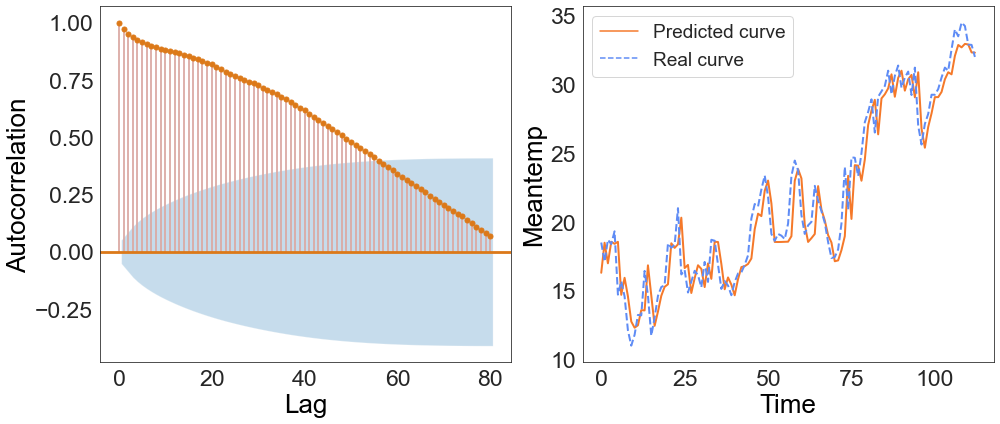

In [26]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf


# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
plt.subplots_adjust(wspace=0.)
vlines_kwargs={'color': '#DBAAA4', 'linestyle': 'solid', 'linewidth': 2, 'alpha': 0.9, 'label': 'Vertical Lines'}

# Plot the ACF in the first subplot
plot_acf(x_train, lags=80, color='#DC7919', ax=axes[0],title='',vlines_kwargs=vlines_kwargs) 
axes[0].set_xlabel('Lag', fontsize=26, color='k')
axes[0].set_ylabel('Autocorrelation',fontsize=26, color='k')
for line in axes[0].lines:
    line.set_linewidth(2.8)
axes[0].tick_params(axis='both', labelsize=23)

# Plot the predicted time series and fitting curve in the second subplot
axes[1].plot(pred_optimal, label='Predicted curve',color='#F5792A')
axes[1].plot(y_test, linestyle='--', color='#5F8CF5', label='Real curve')

axes[1].set_xlabel('Time', fontsize=26, color='k')
axes[1].set_ylabel('Meantemp',fontsize=26, color='k')

axes[1].legend( loc='upper left', ncol=1, fontsize=19,title_fontsize=18)
for line in axes[1].lines:
    line.set_linewidth(2.)
axes[1].tick_params(axis='both', labelsize=23)

# Adjust layout for better spacing
plt.tight_layout()

plt.show()